In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('../figures/')

In [2]:
exp = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/'
).isel(time=slice(365, None)).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()

eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()


/tmp/ipykernel_26882/3248619233.py:137: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


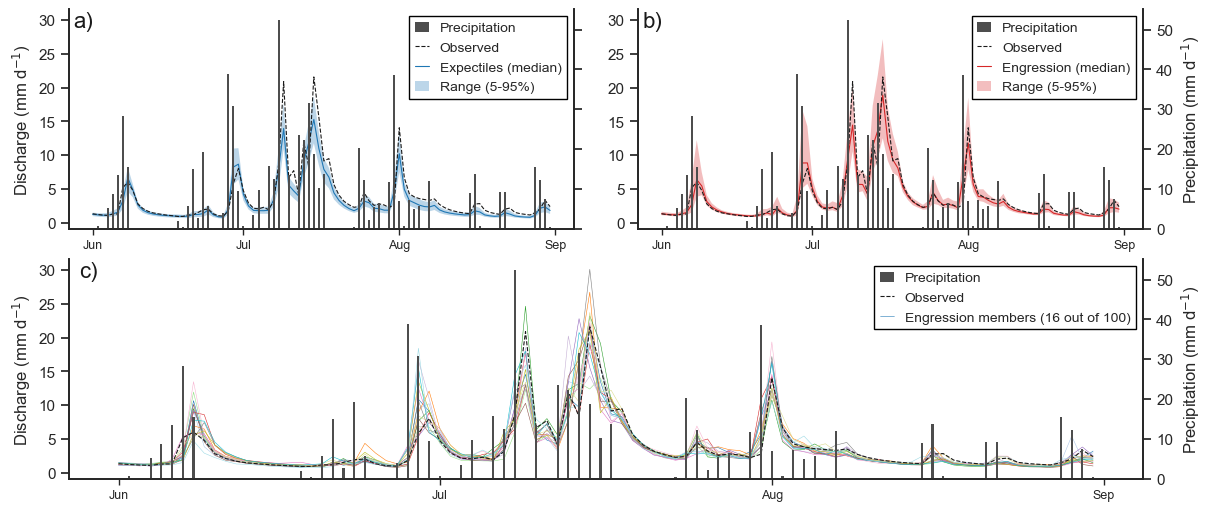

In [3]:
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 2, wspace=0.0)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[1, :], sharey=ax0)

time = slice('2021-06', '2021-08')
station = 'CHFO-0090'

for i, (name, ds) in enumerate(zip(['Expectiles', 'Engression'], [exp, eng])):

    ax = [ax0, ax1][i]

    color = ['tab:blue', 'tab:red'][i]

    ds_sel = ds.sel(station=station, time=time)
    ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=0.8, label='Observed')

    if name == 'Engression':
        med = ds_sel.Qmm_mod.median('member')
        low = ds_sel.Qmm_mod.quantile(0.05, 'member')
        high = ds_sel.Qmm_mod.quantile(0.95, 'member')
    else:
        med = ds_sel.Qmm_mod.sel(member=0.5, method='nearest')
        low = ds_sel.Qmm_mod.sel(member=0.05, method='nearest')
        high = ds_sel.Qmm_mod.sel(member=0.95, method='nearest')

    ax.plot(ds_sel.time, med, lw=0.8, zorder=10, color=color, alpha=1.0, label=f'{name} (median)')
    ax.fill_between(ds_sel.time, low, high, ec='none', alpha=0.3, zorder=-10, fc=color, label='Range (5-95%)')
    # ax.plot(ds_sel.time, low, lw=0.4, zorder=10, color=color)
    # ax.plot(ds_sel.time, high, lw=0.4, zorder=10, color=color)

    ax_twin = ax.twinx()
    ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.3', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.4)

    ax.spines[['top']].set_visible(False)
    ax_twin.spines[['top']].set_visible(False)

    h0, l0 = ax.get_legend_handles_labels()
    h1, l1 = ax_twin.get_legend_handles_labels()

    handles = h1 + h0
    labels = l1 + l0

    legend = ax.legend(
        handles, labels,
        frameon=True,
        # loc='lower center',
        # bbox_to_anchor=(0.5, 1),
        # ncol=2 if i == 0 else 3,
        loc='upper right',
        bbox_to_anchor=(1.0, 1.0),
        ncol=1,
        columnspacing=1,
        handlelength=1)
    blend_legend_color_with_alpha(legend=legend, indices=[3], alpha=0.3)
    ax.set_ylabel('Discharge (mm d$^{-1}$)')
    ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

    if i == 0:
        ax_twin.set_ylabel('')
        ax_twin.set_yticklabels([])
    else:
        ax.set_ylabel('')

    ax.set_rasterization_zorder(-5)

ax = ax2

color = 'tab:red'

ds_sel = eng.sel(station=station, time=time)
ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=0.8, label='Observed')

med = ds_sel.Qmm_mod.median('member')
low = ds_sel.Qmm_mod.quantile(0.05, 'member')
high = ds_sel.Qmm_mod.quantile(0.95, 'member')

colormap = cm.tab20
num_members = 16
colors = [colormap(i / (num_members - 1)) for i in range(num_members)]
for m in range(num_members):
    ax.plot(
        ds_sel.time,
        ds_sel.Qmm_mod.isel(member=m),
        zorder=5,
        color=colors[m],
        ls='-',
        lw=0.4,
        label=f'Engression members ({num_members} out of 100)' if m == 0 else None
    )

ax_twin = ax.twinx()
ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.3', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.2)

ax.spines[['top']].set_visible(False)
ax_twin.spines[['top']].set_visible(False)

h0, l0 = ax.get_legend_handles_labels()
h1, l1 = ax_twin.get_legend_handles_labels()
handles = h1 + h0
labels = l1 + l0

ax.legend(
    handles, labels,
    frameon=True,
    # loc='lower center',
    # bbox_to_anchor=(0.5, 1),
    # ncol=2 if i == 0 else 3,
    loc='upper right',
    bbox_to_anchor=(1.0, 1),
    ncol=1,
    columnspacing=1,
    handlelength=1)

ax.set_ylabel('Discharge (mm d$^{-1}$)')
ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

ax.set_rasterization_zorder(-5)

for ax , label in zip([ax0, ax1, ax2], ['a)', 'b)', 'c)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))  # newline to place it below

    # Set minor ticks to months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    # Show both major and minor tick labels
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='x', which='minor', labelsize=9)

fig.autofmt_xdate()
fig.savefig(SAVE_DIR / 'time_series.eps', dpi=300, bbox_inches='tight')

In [4]:
import geopandas as gpd

In [56]:
obs = gpd.read_file('/net/argon/landclim/kraftb/machflow_engression/obs/shapefile')
obs = obs[obs.mach_ID.isin(eng.station.values)]

In [60]:
obs.watr_nm.values

array(['Broye', 'Reuss', 'Lütschine', 'Sitter', 'Birse', 'Lorze', 'Murg',
       'Töss', 'Rheintaler_Binnenkanal', 'Albula', 'Simme', 'Gürbe',
       'Massa', 'Sense', 'Plessur', 'Werdenberger_Binnenkanal',
       'Weisse_Lütschine', 'Ergolz', 'Grande_Eau', 'Simme', 'Allenbach',
       'Krummbach', 'Rosegbach', 'Berninabach', 'Chamuerabach',
       'Rhone_(Rotten)', 'Lonza', 'Grosstalbach', 'Areuse', 'Alpbach',
       'Minster', 'Ova_dal_Fuorn', 'Glatt', 'Suze', 'Aach',
       'Ova_da_Cluozza', 'Cassarate', 'Dischmabach', 'Saltina',
       'Langeten', 'Riale_di_Roggiasca', 'Breggia', 'Landwasser',
       'Poschiavino', 'Mentue', 'Orbe', 'Necker', 'Murg', 'Emme',
       'Liechtensteiner_Binnenkanal', 'Sionge', 'Glatt', 'Suhre',
       'Rhone_(Rotten)', 'Seez', 'Rein_da_Sumvitg', 'Venoge', 'Aubonne',
       'Dünnern', 'Parimbot', 'Wigger', 'Seyon', 'Sitter', 'Murg',
       'Calancasca', 'Lorze', 'Birse', 'Areuse', 'Allaine', 'Veveyse',
       'Kleine_Emme', 'Schächen', 'Luthern', 'Worble

In [66]:
obs.explore(k=100)